В этом задании, вам необходимо воспроизвести программу, которая обучает Q-таблицу для нахождения кротчайщего пути. Рутинный код, который отображает графики, можно скопировать с лекционного ноутбука - но весь остальной код реккомендуется писать самому.

Далее, нужно провести несколько простых экспериментов с параметрами `epsilon` и `kf_rewards`.

* В первом эксперименте, укажите значения `epsilon = 1` и `kf_rewards = 0.99`.

* Во втором эксперименте, укажите значения `epsilon = 1` и `kf_rewards = 1`.

* В третьем эксперименте, укажите значение `epsilon = 0` и `kf_rewards = 0.99`.

* В четвертом эксперименте, укажите значение `epsilon = 1` и `kf_rewards = 0`.

Имейте введу, что значение `epsilon` будет постепенно падать в ходе обучение алгоритма.

После того, как вы проведёте все 4 эксперимента, напишите свои выводы касаемо того, как агент обучается при каждом наборе параметров.

In [1]:
#Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import clear_output
import time
sns.set_style('darkgrid')

Сначала, нам нужно написать код для создания среды, агента, а также правила по которым агент может взаимодействовать с средой. 



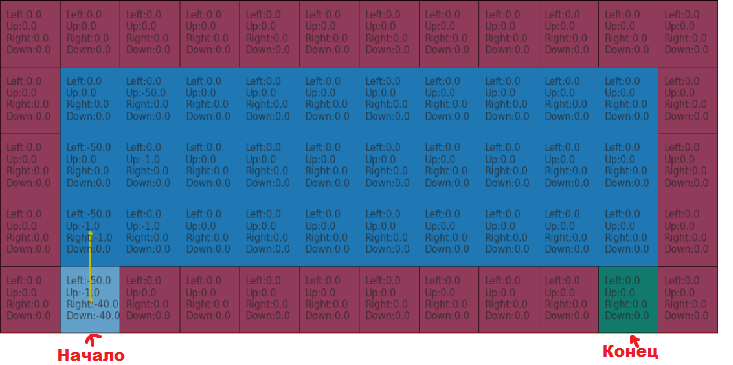

Агент может двигаться с любой синей ячейки влево, вправо, вверх, или вниз. Его цель - пройти с начальной ячейки до конечной, и при этом не попадать на фиолетовые ячейки. Игра заканчивается выйгрышем при попадании на конечную ячейку, либо проигрышем при попадании на любую из фиолетовых. Также желательно пройти до финиша кротчайщим возможным путём.

Путь, который прошёл наш агент, размечается жёлтой линией.

Эта задача очень простая, и количество возможных, уникальных состояний здесь немного. По этому задача является демонстративной (с её помощью покажем суть основного алгоритма Q-learning), и её можно решить без применение нейронных сетей.

In [2]:
#Здесь содержиться весь нужный кож для создания среды.


#Назначаем награду в -50 очков за попадание в плохую ячейку, 
#-1 за обычный шаг (это нужно чтобы находить кротчайший путь, 
#и +10 очков когда агент попадает в финальную ячейку)
points = [-50, -1, 10]
rewards = np.zeros((5,13,4)) # Инициализируем Q-таблицу
step = ([[-1, 0], [0, 1], [1, 0], [0, -1]]) #Двигаться влево, вправо, вверх, и вниз.
start_position = np.array([1,0]) # стартовая позиция
finish_position = np.array([10,0]) # финишная позиция
rewards[start_position[1],start_position[0]] = points[0]+10 # Начальные награды в стартовой точнке (инициализируем как -40 что бы ускорить обучение)
        
# Функция создания игрового поля
def createField(): 
  fig, ax = plt.subplots(1, figsize=(24, 10)) # Создаем полотно
  rect = patches.Rectangle((0, 5), 12, -5, linewidth = 2, edgecolor = 'black') # Создаем прямоугольник вокруг всего игрового поля
  ax.add_patch(rect) # Рисуем прямоугльник
  rect = patches.Rectangle((1,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'white', alpha = 0.3) # Создаем прямоугльник стартовой позиции
  ax.add_patch(rect) ## Рисуем прямоугльник        
        # Рисуем "опасные" прямоугольники по границе игрового поля
  for i in range(2,10):
    rect = patches.Rectangle((i,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  for i in range(1,12):
    rect = patches.Rectangle((i,5), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  for i in range(1, 6):
    rect = patches.Rectangle((0,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  for i in range(1, 5):
    rect = patches.Rectangle((11,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)        
  rect = patches.Rectangle((10,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'green', alpha = 0.4) # Создаем прямоугльник финишной позиции
  ax.add_patch(rect) # Рисуем прямоугльник
  plt.xticks(np.arange(13))
  plt.yticks(np.arange(6))
  return fig,ax
    
# Функция получения случайного хода
def GetNextRandomPosition(current_position, positions):        
  while True:
    idx = np.random.randint(4) # Генерируем случайное значение (0,1,2,3)
    next_position = current_position + step[idx] # Получаем новое положение
              
    # Если награда за движение в указанную точку не равна минимальное (означает, что двигаемся в "опасную" точку)
    if rewards[current_position[1], current_position[0], idx] != points[0]:
      # Если не вышли за границу игрового поля
      if next_position.min() >= 0 and next_position[1] < 5 and next_position[0] < 12:
        # Если это не первый шаг
        if len(positions)>1:
          # Если не делаем шаг назад
          if list(next_position) != positions[-2]:                            
            return next_position
        else:
          return next_position

# Функция: сыграть одну партию
def playGame(num):
  global epsilon

  clear_output(wait = True) # очищаем экран  
  current_position = start_position # Текущая позиция равна стартовой
  positions = [list(start_position)] # В список позиций записываем стартовую позицию
  while True:                
    f,a = createField() # Создаем игровое поле
    # Генерируем случайное значение от 0 до 1. И если оно меньше текущего значения epsilon
    if np.random.random() < epsilon:
      # Делаем случайный шаг
      next_position = GetNextRandomPosition(current_position, positions)
    # В противном случае
    else:                
      re = np.argmax(rewards[current_position[1], current_position[0]]) # Получаем максимальное вознаграждение из текущей позиции
      next_position = current_position + step[re] # Делаем шаг по пути максимального вознаграждения
      # Если вышли за пределы игрового поля
      if next_position.min() < 0 or next_position[1] > 4 or next_position[0] > 11:
        #то перезаписываем новое положение на случайное
        next_position = GetNextRandomPosition(current_position, positions)                    
                # Если это не первый шаг
        if len(positions) > 1:
          # Если сделали шаг назад
          if list(next_position) == positions[-2]:
            # Перезаписываем новое положение на случайное
            next_position = GetNextRandomPosition(current_position, positions)
    # Если epsilon больше 0.01
    if epsilon > 0.01:
      epsilon *= 0.999 # Изменяем значение (экспоненциальный спад epsilon)  
    positions.append(list(next_position)) # Добавляем в список позиций новое положение агента
    # Визуализируем путь игрока желтыми линиями
    for p in range(len(positions)-2):
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth = 4)            
    # Последний шаг рисуем зелёной линией
    x = [positions[-2][0] + 0.5, positions[-1][0] + 0.5]
    y = [positions[-2][1] + 0.5, positions[-1][1] + 0.5]
    a.plot(x, y, marker = 'o', color = 'g', linewidth = 4)
            
    # Печатаем текстовую информацию (награды в каждой ячейке игрового поля)
    for i in range(5):
      for j in range(12):
        txt = 'Left:' + str(round(rewards[i,j,0], 2)) + '\n' +\
          'Up:' + str(round(rewards[i,j,1], 2)) + '\n' +\
          'Right:' + str(round(rewards[i,j,2], 2)) + '\n' +\
          'Down:' + str(round(rewards[i,j,3], 2))                
        a.text(j + 0.1, i + 0.2, txt, fontsize = 16, alpha = 0.7) 
    plt.title(f"Игра № {num + 1}:", fontsize = 16)
    plt.show()
            
    current_position = next_position # Перезаписываем текущее положение
    clear_output(wait = True) # Очищаем экран
            
    # Если попали в "опасную" точку или дошли до финиша
    if next_position[1] == 0 or next_position[1] == 4 or next_position[0] == 0 or next_position[0] == 11:
      break # Выходим из цикла 
  return positions # Возврщаем список позиций
    
def train(count = 20, auto = True):
  global rewards

  for num in range(count): #В каждой партии
    positions = playGame(num) #Играем партию и записываем позиции что бы посчитать награды
    f,a = createField() #Создаем игровое поля
              
    for p in range(len(positions) - 1): #Рисуем пройденный путь агента
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth=4)
              
      action = step.index(list(np.array(positions[-1]) - np.array(positions[-2])))
      rew = points[0] #Извлекаем награды за действие
      if positions[-1] == list(finish_position): #Если достигли финишную клетку
        rew = points[2] #Награждаем 10 очков
      rewards[positions[-2][1],positions[-2][0]][action] = rew #Обновляем матрицу наград
      y = 1
      if len(positions)>2: #Если совершили больше чем 2 шага
        for i in range(len(positions)-3, -1, -1): #Считаем награды для всех клеток, начиная с последней
          action = step.index(list(np.array(positions[i+1]) - np.array(positions[i])))
          ###ВАЖНОЕ###
          #Рекурсивное уравнение Бэллмена в коде
          rewards[positions[i][1],positions[i][0]][action] = points[1] + y * max(rewards[positions[i+1][1],positions[i+1][0]]) #Штрафуем за 1 очко на наждый шаг, прибавляем награжу за следующий шаг
          ###############
        y *= kf_rewards #Скалируем награды в соответствии kf_rewards
      for i in range(5):
        for j in range(12): #Записываем вычисленную Q-таблицу
          txt = 'Left:'+str(round(rewards[i,j,0],2))+'\n'+\
            'Up:'+str(round(rewards[i,j,1],2))+'\n'+\
            'Right:'+str(round(rewards[i,j,2],2))+'\n'+\
            'Down:'+str(round(rewards[i,j,3],2))                
          a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7)      
      plt.show()
      clear_output(wait=True) # Очищаем экран

# Обучаем алгоритм

Сначала ставим `epsilon = 1`, `kf_rewards = 0.99`

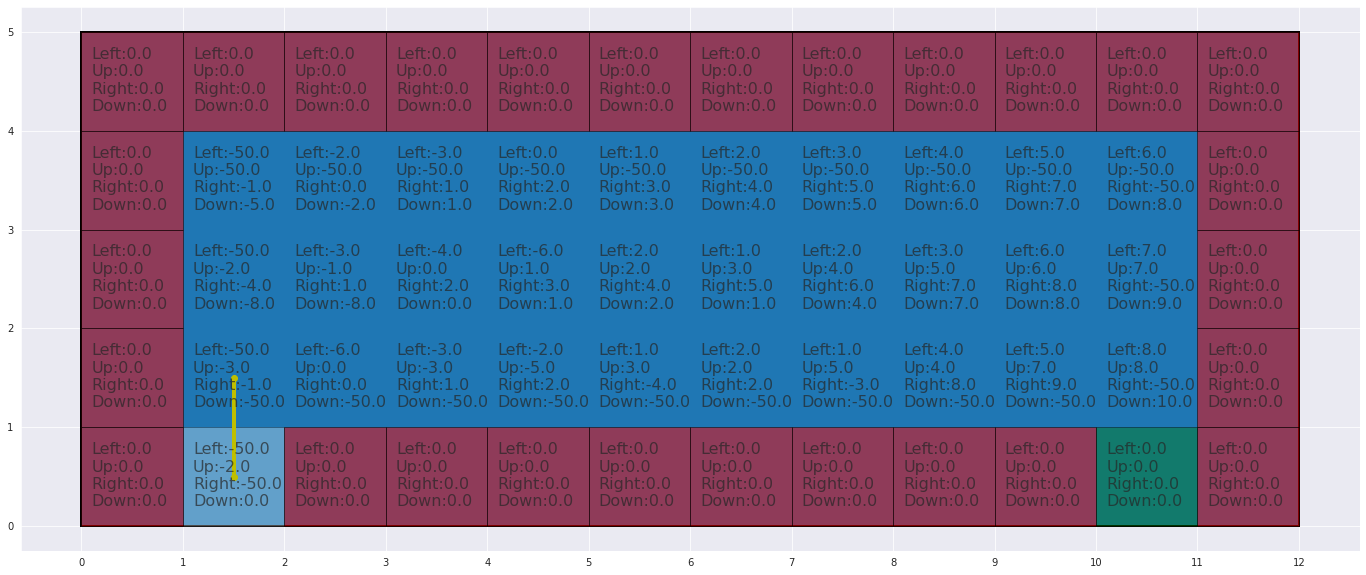

In [3]:
rewards = np.zeros((5,13,4)) # Инициализируем Q-таблицу

epsilon = 1.0 # параметр случайного хода Epsilon Greedy
kf_rewards = 0.99 # коэффициент учета будующих награждений 

#Обучаем агента на 250 эпизодов, смотрим как он обучается.
position = train(250)

Затем ставим `epsilon = 1`, `kf_rewards = 1`

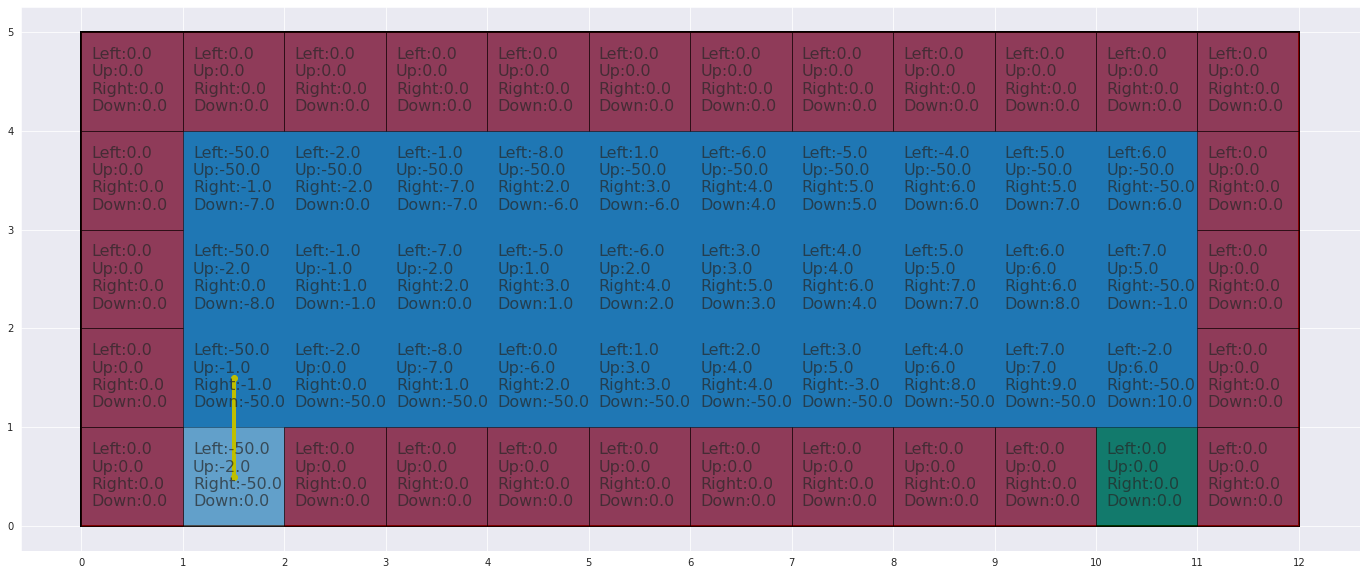

In [4]:
rewards = np.zeros((5,13,4)) # Инициализируем Q-таблицу

epsilon = 1.0 # параметр случайного хода Epsilon Greedy
kf_rewards = 1.0 # коэффициент учета будующих награждений 

#Обучаем агента на 250 эпизодов, смотрим как он обучается.
position = train(250)

Затем ставим `epsilon = 0`, `kf_rewards = 0.99`

In [ ]:
rewards = np.zeros((5,13,4)) # Инициализируем Q-таблицу

epsilon = 0 # параметр случайного хода Epsilon Greedy
kf_rewards = 0.99 # коэффициент учета будующих награждений 

#Обучаем агента на 250 эпизодов, смотрим как он обучается.
position = train(250)

###Ходит бесконечным циклом!!!

Затем ставим `epsilon = 1`, `kf_rewards = 0`

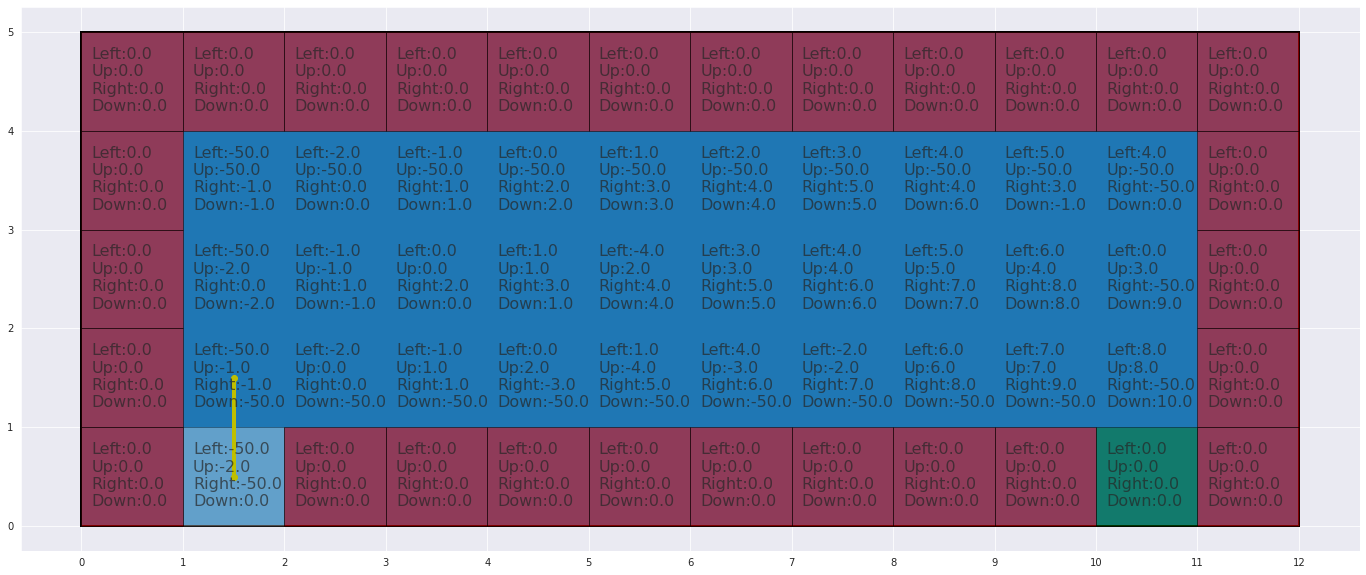

In [7]:
rewards = np.zeros((5,13,4)) # Инициализируем Q-таблицу

epsilon = 1 # параметр случайного хода Epsilon Greedy
kf_rewards = 0 # коэффициент учета будующих награждений 

#Обучаем агента на 250 эпизодов, смотрим как он обучается.
position = train(250)

**Выводы:**

* При `epsilon = 1` и `kf_rewards = 0.99` алгоритм обучается нормально, но всё таки не смогла обучиться до конца из-за слишком маленького количество эпох.

* При `epsilon = 1` и `kf_rewards = 1` алгоритм не можем обучиться, т.к. награда не уменьшается с временем. В итоге, все пути которые рано или поздно приводят к награде рассматриваются как одинаково хорошими.

* При `epsilon = 0` и `kf_rewards = 0.99` алгоритм не может обучиться т.к. он не исследует среду. В итоге он ходит бесконечным циклом.

* При `epsilon = 1` и `kf_rewards = 0` алгоритм не может обучиться т.к. награды не распростроняются обратно, и в итоге он не видит награды, которые он может получить в будующем.